In [1]:
import apogee.tools.read as apread
import matplotlib.pyplot as plt
import apogee.tools.path as apogee_path
from apogee.tools import bitmask

import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn

from apoNN.src.datasets import ApogeeDataset

from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
apogee_path.change_dr(16)

In [2]:
allStar= apread.allStar(rmcommissioning=True,main=False,ak=True, akvers='targ',adddist=False)


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/apogee/tools/read.py:303: RuntimeWarning: Extinction-corrected J,H,K not added because esutil is not installed
  warnings.warn("Extinction-corrected J,H,K not added because esutil is not installed",RuntimeWarning)


In [3]:
upper_temp_cut = allStar["Teff"]<5000
lower_temp_cut = allStar["Teff"]>4000
lower_g_cut = allStar["logg"]>1.5
upper_g_cut = allStar["logg"]<3
snr_cut = allStar["SNR"]>100
snr_highcut = allStar["SNR"]<500
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5



combined_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut & snr_cut & snr_highcut & feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut


In [4]:
cut_allStar = allStar[combined_cut]

### Parameters


In [5]:
n_batch = 64
n_z = 20
n_bins = 8575
lr = 0.0001
n_datapoints = 5000

### Training

In [6]:
dataset = ApogeeDataset(cut_allStar[:n_datapoints])
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = n_batch,
                                     shuffle= False,
                                     drop_last=True)

In [7]:
encoder = Feedforward([n_bins,2048,512,128,n_z],activation=nn.LeakyReLU()).to(device)
decoder = Feedforward([n_z,128,512,2048,4096,n_bins],activation=nn.LeakyReLU()).to(device)

autoencoder = Autoencoder(encoder,decoder,n_bins=n_bins).to(device)
optimizer_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=lr)

In [8]:
#autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/pretrained/ae1")
optimizer_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=lr)

In [9]:
loss = nn.L1Loss()



In [ ]:
for i in range(20000):
    for j,(x,u,idx) in enumerate(loader):

        optimizer_autoencoder.zero_grad()
        x_pred,z = autoencoder(x.to(device))

        err_pred = loss(x_pred,x.to(device))

        err_tot = err_pred
        err_tot.backward()
        optimizer_autoencoder.step()
        if j%100==0:
            print(f"err:{err_tot},err_pred:{err_pred}")


In [ ]:
print(i)

In [ ]:
torch.min(x)

In [66]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/nn/ae/ae2/ae_3000.p")
#autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/nn/random/ae1")

## Latent Visualization

In [67]:
def get_z(idx,dataset):
    _,z = autoencoder(dataset[idx][0].to(device).unsqueeze(0))
    return z

In [68]:
def get_v(idx,dataset,feedforward):
    _,z = autoencoder(dataset[idx][0].to(device).unsqueeze(0))
    v = feedforward(z)
    return v

In [69]:
n_datapoints = 5000
z_array = np.array([get_z(i,dataset).detach().cpu().numpy() for i in range(n_datapoints)]).squeeze()
z_calibrated = (z_array- np.mean(z_array,axis=0)).T

In [70]:
z_calibrated.shape

(40, 5000)

In [71]:
abundances_array = np.array([cut_allStar["Teff"],cut_allStar["logg"],cut_allStar["Fe_H"],cut_allStar["O_FE"],cut_allStar["C_FE"],cut_allStar["Na_FE"],cut_allStar["Mg_FE"],cut_allStar["Si_FE"]])[:,:n_datapoints].T
abundances_array = (abundances_array-np.min(abundances_array,axis=0))/(np.max(abundances_array,axis=0)-np.min(abundances_array,axis=0)).T
abundances_calibrated = (abundances_array-np.mean(abundances_array,axis=0)).T

In [72]:
W_est =np.dot(abundances_calibrated,np.linalg.pinv(z_calibrated))

In [73]:
abundances_calibrated_est = np.dot(W_est,z_calibrated)


(-0.8, 0.6)

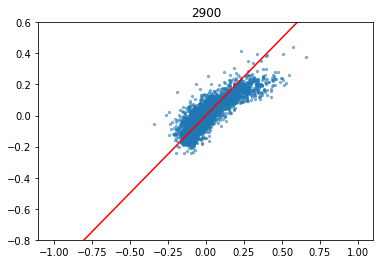

In [81]:
idx = 3
plt.scatter(abundances_calibrated[idx],abundances_calibrated_est[idx],s=5,alpha=0.5)
plt.plot([-1,1],[-1,1],c="red")
plt.title("2900")
plt.ylim(-0.8,0.6)

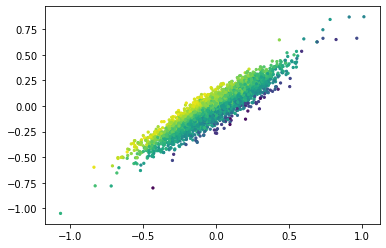

In [47]:
plt.scatter(abundances_calibrated_est[0],abundances_calibrated_est[1],s=5,c=abundances_calibrated[2][:5000])


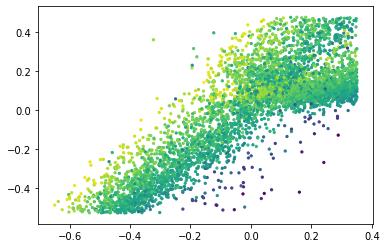

In [48]:
plt.scatter(abundances_calibrated[0][:5000],abundances_calibrated[1][:5000],s=5,c=abundances_calibrated[2][:5000])


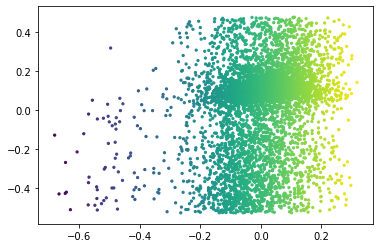

In [29]:
plt.scatter(abundances_calibrated[2][:5000],abundances_calibrated[1][:5000],s=5,c=abundances_calibrated[2][:5000])


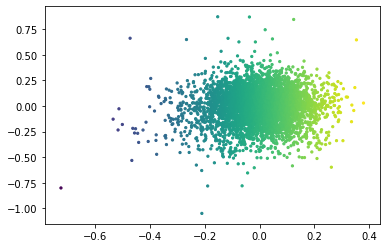

In [55]:
plt.scatter(abundances_calibrated_est[2][:5000],abundances_calibrated_est[1][:5000],s=5,c=abundances_calibrated_est[2][:5000])


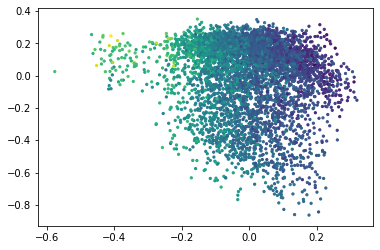

In [34]:
plt.scatter(abundances_calibrated_est[2][:5000],abundances_calibrated_est[0][:5000],s=5,c=abundances_calibrated_est[3][:5000])


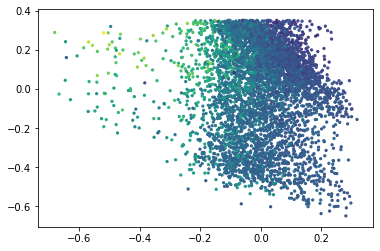

In [33]:
plt.scatter(abundances_calibrated[2][:5000],abundances_calibrated[0][:5000],s=5,c=abundances_calibrated[3][:5000])


In [ ]:
idx = 7
plt.scatter(abundances_calibrated[idx],abundances_calibrated_est[idx],s=5,alpha=0.5)
plt.plot([-1,1],[-1,1],c="red")
plt.title("2900")
plt.ylim(-0.8,0.6)

In [ ]:
abundances_calibrated[0].shape

In [ ]:
plt.hist(abundances_calibrated[4],bins=100)

In [ ]:
plt.scatter(abundances_calibrated[0],abundances_calibrated_est[0],s=5,alpha=0.5)
plt.title("2900")
plt.ylim(-0.8,0.6)

In [ ]:
plt.scatter(abundances_calibrated[0],abundances_calibrated_est[0],s=5,alpha=0.5)
plt.title("2900")
plt.ylim(-0.8,0.6)

In [ ]:
plt.scatter(abundances_calibrated[0][0:500],abundances_calibrated[1][0:500],s=5,alpha=0.5)

In [ ]:
plt.scatter(abundances_calibrated_est[0][0:1000],abundances_calibrated_est[1][0:1000],s=5,alpha=0.5)

## Non-linear better

### Setup

In [ ]:
autoencoder

In [ ]:
feedforward = Feedforward([40,256,128,1],activation=nn.SELU()).to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(feedforward.parameters(),lr=0.0001)


In [ ]:
truth_tensor = torch.tensor(abundances_calibrated[7]).to(device)


In [ ]:
feedforwards = []
for idx_estimated in range(len(abundances_calibrated)):
    truth_tensor = torch.tensor(abundances_calibrated[idx_estimated]).to(device)
    
    feedforward = Feedforward([40,512,256,128,1],activation=nn.SELU()).to(device)
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(feedforward.parameters(),lr=0.0001)

    for i in range(5):
        for j,(x,u,idx) in enumerate(loader):
            optimizer.zero_grad()
            x_pred,z = autoencoder(x.to(device))
            pred = feedforward(z.detach())
            true = truth_tensor[idx]

            err = loss(pred,true.unsqueeze(1))    
            err.backward()
            optimizer.step()
            if j%100==0:
                print(f"epoch:{i},err:{err}")
                
    feedforwards.append(feedforward)


In [ ]:
abundances_non_linear = []
for feedforward in feedforwards:
    ab = np.array([get_v(i,dataset,feedforward).detach().cpu().numpy() for i in range(n_datapoints)]).squeeze()
    abundances_non_linear.append(ab)

In [ ]:
nonlinear_array = np.array([get_v(i,dataset).detach().cpu().numpy() for i in range(n_datapoints)]).squeeze()


In [ ]:
plt.scatter(abundances_calibrated[0],nonlinear_array,s=5,alpha=0.5)
plt.title("2900")
plt.ylim(-0.8,0.6)
plt.xlim(-0.8,0.6)

In [ ]:
idx = 5
plt.scatter(abundances_calibrated[idx],abundances_non_linear[idx],s=5,alpha=0.5)
plt.plot([-1,1],[-1,1],c="red")

plt.title("2900")
plt.ylim(-0.8,0.6)
plt.xlim(-0.8,0.6)